#Model Development and Evaluation

This notebook presents the development and evaluation of clustering models applied to PCA-reduced data. The k-means and DBSCAN clustering methods are compared to identify optimal segmentation of the dataset.

In [13]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.stats import ttest_ind

In [4]:
# The PCA results are loaded from a CSV file
X_pca = pd.read_csv('pca_results.csv').values

#k-means Clustering: Testing Different Numbers of Clusters

Different values of k (from 2 to 10) are tested to determine the optimal number of clusters.
Two evaluation metrics are used:

Silhouette Score (higher values indicate better cluster cohesion and separation)
Davies-Bouldin Index (lower values indicate better clustering)

In [5]:
K = range(2, 11)
sil_scores = []
db_scores  = []

for k in K:
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=12, random_state=42)
    labels = kmeans.fit_predict(X_pca)

    sil_scores.append(silhouette_score(X_pca, labels))
    db_scores.append(davies_bouldin_score(X_pca, labels))

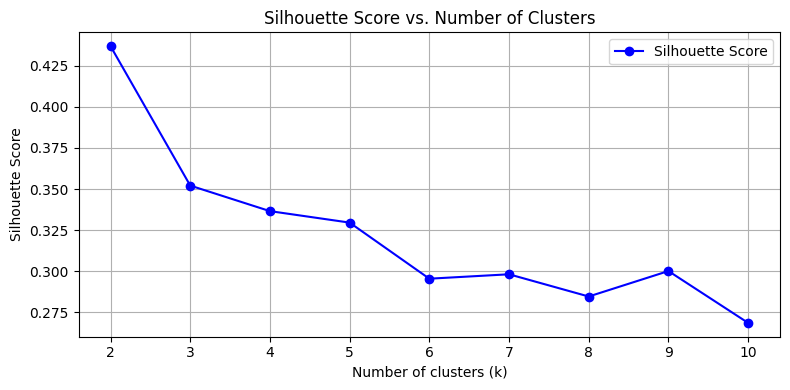

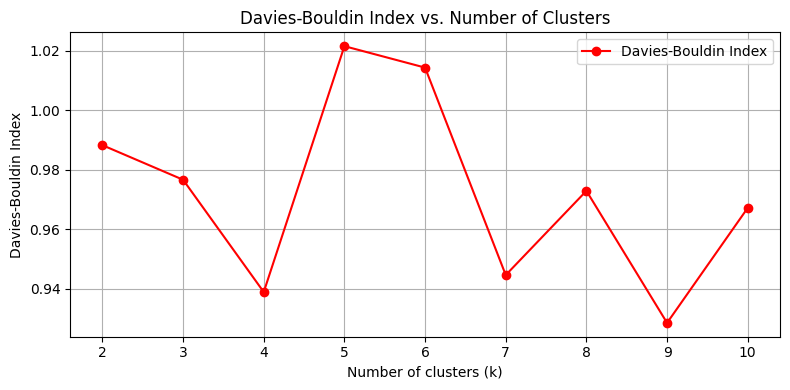

In [6]:
# Silhouette Scores and Davies-Bouldin Index values for each k are plotted to assist in selecting the optimal number of clusters
plt.figure(figsize=(8,4))
plt.plot(K, sil_scores, 'bo-', label='Silhouette Score')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(K, db_scores, 'ro-', label='Davies-Bouldin Index')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
# The number of clusters corresponding to the highest Silhouette Score is selected as optimal. The Davies-Bouldin Index is also reported
best_k = K[np.argmax(sil_scores)]
print(f"Best k by Silhouette: {best_k}")
print(f"Corresponding Davies–Bouldin Index: {db_scores[best_k - 2]:.3f}")

Best k by Silhouette: 2
Corresponding Davies–Bouldin Index: 0.988


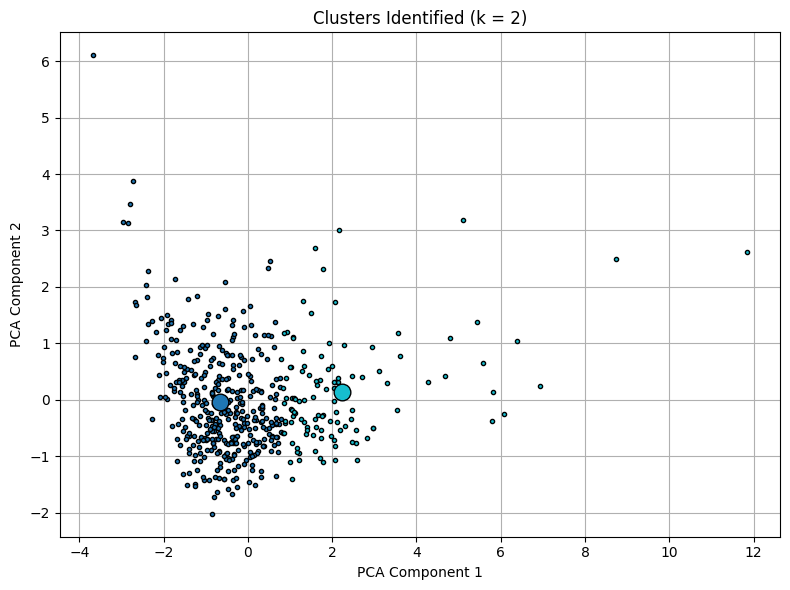

In [8]:
#k-means clustering is performed using the optimal number of clusters
kmeans_final = KMeans(n_clusters=best_k, init='k-means++', n_init=12, random_state=42)
labels_final = kmeans_final.fit_predict(X_pca)
k_means_cluster_centers = kmeans_final.cluster_centers_

X_plot = X_pca[:, :2]
plt.figure(figsize=(8, 6))
colors = plt.cm.tab10(np.linspace(0, 1, best_k))

for k, col in zip(range(best_k), colors):
    members = (labels_final == k)
    cluster_center = k_means_cluster_centers[k]
    plt.plot(X_plot[members, 0], X_plot[members, 1], '.', markerfacecolor=col,
             markeredgecolor='k', markersize=6)
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=12)

plt.title(f'Clusters Identified (k = {best_k})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# A DataFrame containing PCA components and cluster labels is saved to a CSV file.
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
X_pca_df['cluster'] = labels_final
X_pca_df.to_csv('pca_clusters_with_dbi.csv', index=False)
print("Clusters with DBI evaluation saved to 'pca_clusters_with_dbi.csv'")

Clusters with DBI evaluation saved to 'pca_clusters_with_dbi.csv'


#DBSCAN Clustering

DBSCAN clustering is performed on scaled PCA data.

In [10]:
X_scaled = StandardScaler().fit_transform(X_pca)

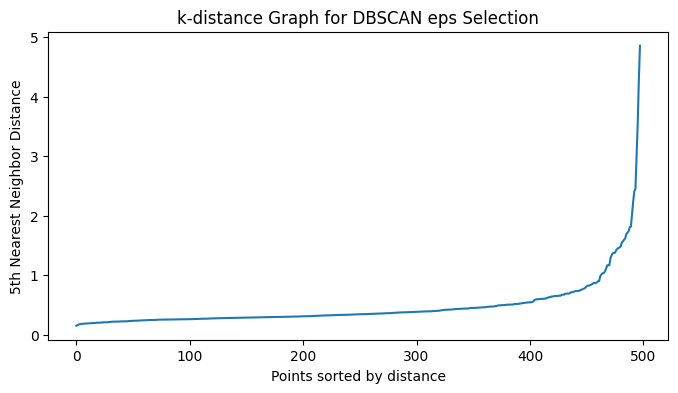

In [11]:
#The k-distance graph is plotted to determine an appropriate epsilon (eps) parameter for DBSCAN.
min_samples = 5
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, min_samples - 1], axis=0)

plt.figure(figsize=(8,4))
plt.plot(distances)
plt.ylabel(f'{min_samples}th Nearest Neighbor Distance')
plt.xlabel('Points sorted by distance')
plt.title('k-distance Graph for DBSCAN eps Selection')
plt.show()

In [12]:
dbscan = DBSCAN(eps=4, min_samples=6)
labels_db = dbscan.fit_predict(X_scaled)

n_clusters_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise = list(labels_db).count(-1)

print(f"DBSCAN detected {n_clusters_db} clusters (excluding noise)")
print(f"Number of noise points: {n_noise}")

if n_clusters_db > 1:
    sil_db = silhouette_score(X_scaled, labels_db)
    dbi_db = davies_bouldin_score(X_scaled, labels_db)
    print(f"Silhouette Score (DBSCAN): {sil_db:.3f}")
    print(f"Davies-Bouldin Index (DBSCAN): {dbi_db:.3f}")
else:
    print("Insufficient clusters for metric computation.")

DBSCAN detected 1 clusters (excluding noise)
Number of noise points: 1
Insufficient clusters for metric computation.


In [15]:
# The original gene expression data prior to PCA is loaded for further analysis
df = pd.read_csv('df_rounded.csv', index_col=0)

In [16]:
# The cluster assignments are appended to the expression data DataFrame
assert df.shape[0] == len(labels_final), "Sample count and cluster labels do not match."

df['cluster'] = labels_final

In [17]:
# Expression data is partitioned by cluster, and mean expression and fold change are computed per cluster
group_0 = df[df['cluster'] == 0].drop(columns='cluster')
group_1 = df[df['cluster'] == 1].drop(columns='cluster')

mean_0 = group_0.mean()
mean_1 = group_1.mean()
fold_change = mean_1 / (mean_0 + 1e-6)

In [18]:
# A t-test is performed for each miRNA to evaluate differential expression between clusters
p_values = []
for miRNA in df.columns[:-1]:  # exclude 'cluster' column
    stat, p = ttest_ind(group_0[miRNA], group_1[miRNA], equal_var=False)
    p_values.append(p)

In [20]:
# Results are compiled into a DataFrame, including mean expression, fold change, p-values, and classification
df_results = pd.DataFrame({
    'miRNA': df.columns[:-1],
    'mean_cluster_0': mean_0.values,
    'mean_cluster_1': mean_1.values,
    'fold_change_cluster1_vs_0': fold_change.values,
    'p_value': p_values
})

def classify_expression(row):
    if row['p_value'] < 0.05 and row['fold_change_cluster1_vs_0'] > 2:
        return 'upregulated in cluster 1'
    elif row['p_value'] < 0.05 and row['fold_change_cluster1_vs_0'] < 0.5:
        return 'upregulated in cluster 0'
    else:
        return 'not significant'

df_results['differential_expression'] = df_results.apply(classify_expression, axis=1)

In [21]:
df_results

,miRNA,mean_cluster_0,mean_cluster_1,fold_change_cluster1_vs_0,p_value,differential_expression
0,hsa-mir-200c,13915.894906,10541.782746,0.757535,8.045988e-08,not significant
1,hsa-mir-145,4371.471414,9635.156982,2.204099,1.275474e-22,upregulated in cluster 1
2,hsa-mir-221,147.285891,365.407684,2.480942,3.624527e-33,upregulated in cluster 1
3,hsa-mir-222,36.203477,94.243939,2.603174,1.955995e-30,upregulated in cluster 1


# Molecular Subtype Annotation Based on Clusters
Cluster 1 → TMPRSS2-ERG- Subtype:
This cluster showed overexpression of downregulated miRNAs in TMPRSS2-ERG+ tumours.

Cluster 0 → TMPRSS2-ERG+ Subtype:
This cluster exhibited downregulation of miRNAs typically associated ERG+ fusion types tumors.  Key markers included: miR-145, miR-221, miR-222, miR-200c.

In [26]:
cluster_subtype_map = {
    0: 'TMPRSS2-ERG+',
    1: 'TMPRSS2-ERG-'
}

sample_names = df.index.tolist()

df_clusters = pd.DataFrame({
    'Sample': sample_names,
    'Cluster': labels_final,
    'Subtype': [cluster_subtype_map[c] for c in labels_final]
})

df_clusters.to_csv('sample_subtypes_assigned.csv', index=False)
print("Sample subtype annotations saved to 'sample_subtypes_assigned.csv'")


Sample subtype annotations saved to 'sample_subtypes_assigned.csv'


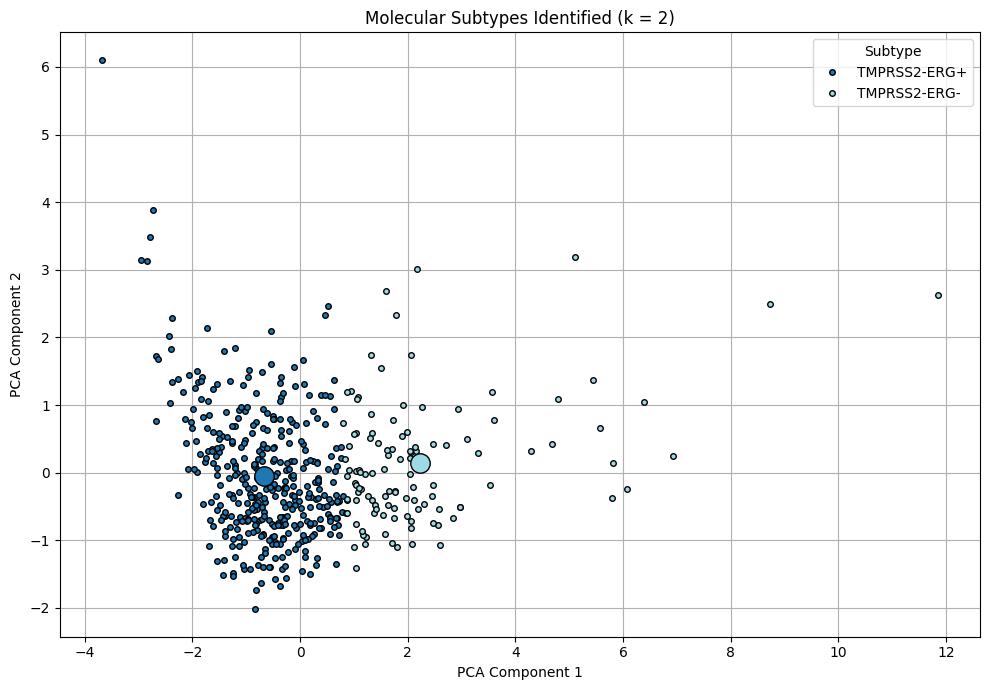

In [27]:
# Clusters are visualized on the PCA components plot, colored by molecular subtype
plt.figure(figsize=(10, 7))
colors = plt.cm.tab20(np.linspace(0, 1, best_k))

for k, col in zip(range(best_k), colors):
    members = (labels_final == k)
    subtype_name = cluster_subtype_map[k]
    plt.plot(X_plot[members, 0], X_plot[members, 1], '.', markerfacecolor=col,
             markeredgecolor='k', markersize=8, label=subtype_name)
    cluster_center = k_means_cluster_centers[k]
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

plt.title(f'Molecular Subtypes Identified (k = {best_k})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Subtype')
plt.grid(True)
plt.tight_layout()
plt.show()